In [1]:
# importing library
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings("ignore")


In [2]:
#connecting to pre-processed data 
import sqlite3
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str

#final.to_sql('Reviews', conn, flavor=None, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

In [4]:
# Loading data from the filtered / processed database
import pandas as pd
filtered_data = pd.read_sql_query("""Select * from reviews ORDER by Time limit 100000 """,conn)
filtered_data.head(3)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
1,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,b'rememb see show air televis year ago child s...
2,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,b'beetlejuic well written movi everyth excel a...


In [5]:
filtered_data['Score'].value_counts()

positive    87729
negative    12271
Name: Score, dtype: int64

In [7]:
labels = filtered_data['Score']

def lab_to_bin(x):
    if x == 'positive':
        return 1
    else:
        return 0
labels_bin = labels.map(lab_to_bin)

final =  filtered_data['Text']

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

#Splitting data into train test and cross validation 
 
X_1, X_test, y_1, y_test = train_test_split(final, labels_bin, test_size=0.3, random_state=0,shuffle = False)

# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = train_test_split(X_1, y_1, test_size=0.3,shuffle = False)



# BAG OF WORDS 

In [9]:
#Creating bag of words and vectorizing it
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing
count_vect = CountVectorizer(ngram_range=(1,2)) 
final_counts_tr = count_vect.fit_transform(X_tr.values)
final_counts_cv = count_vect.transform(X_cv.values)
final_counts_test = count_vect.transform(X_test.values)
final_counts_tr = preprocessing.normalize(final_counts_tr)
final_counts_cv = preprocessing.normalize(final_counts_cv)
final_counts_test = preprocessing.normalize(final_counts_test)


### Simple Cross Validation

In [10]:
def fold_cross_validation(Xtrain,Ytrain,Ytest,cv_val):
    
    

# creating odd list of K for KNN
    myList = list(range(0,50))
    neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
    cv_scores = []

# perform 10-fold cross validation
    for k in neighbors:
        knn = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(knn, Xtrain, Ytrain, cv=cv_val, scoring='f1')
        cv_scores.append(scores.mean())

# changing to misclassification error
    MSE = [1 - x for x in cv_scores]

# determining best k
    optimal_k = neighbors[MSE.index(min(MSE))]
    print('\nThe optimal number of neighbors is %d.' % optimal_k)

# plot misclassification error vs k 
    plt.plot(neighbors, MSE)

    for xy in zip(neighbors, np.round(MSE,3)):
        plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

    plt.xlabel('Number of Neighbors K')
    plt.ylabel('Misclassification Error')
    plt.show()

    print("the misclassification error for each k value is : ", np.round(MSE,3))

In [11]:
def KNN_optimal(Xtrain,Ytrain,Xtest,Ytest,optimal_k):
    knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k)

# fitting the model
    knn_optimal.fit(Xtrain,Ytrain)

# predict the response
    pred = knn_optimal.predict(Xtest)

# evaluate accuracy
    acc = accuracy_score(y_test, pred) * 100
    print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))
    print("Accuracy on test set: %0.3f%%"%(accuracy_score(Ytest, pred)*100))
    print("Precision on test set: %0.3f"%(precision_score(Ytest, pred)))
    print("Recall on test set: %0.3f"%(recall_score(Ytest, pred)))
    print("F1-Score on test set: %0.3f"%(f1_score(Ytest, pred)))
    matrix = confusion_matrix(y_test,pred)
    sns.heatmap(matrix,annot=True,fmt="d",linewidths=.5)
    plt.title("confusion matrix for optimal KNN")
    plt.show()
    

In [13]:
from sklearn.model_selection import RandomizedSearchCV

knn = KNeighborsClassifier(algorithm='brute')
def brute_force_knn(Xtrain, Ytrain,Xtest,Ytest):
    tuned_parameters ={  'n_neighbors': np.arange(1,30,5)}
    model = RandomizedSearchCV(knn,param_distributions=tuned_parameters)
    model.fit(Xtrain, Ytrain)
    pred=model.predict(Xtest)
    conf_mat = confusion_matrix(Ytest,pred)
    sns.heatmap(conf_mat,annot=True,fmt="d",linewidths=.5)
    plt.show()
    print("The best parameters are %s with a score of %0.2f"
      % (model.best_params_, model.best_score_))
    print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, pred)*100))
    print("Precision on test set: %0.3f"%(precision_score(y_test, pred)))
    print("Recall on test set: %0.3f"%(recall_score(y_test, pred)))
    print("F1-Score on test set: %0.3f"%(f1_score(y_test, pred)))

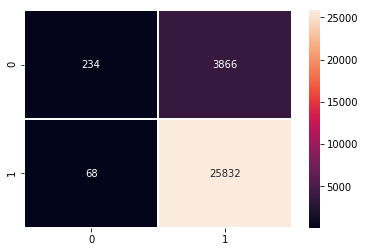

The best parameters are {'n_neighbors': 16} with a score of 0.89
Accuracy on test set: 86.887%
Precision on test set: 0.870
Recall on test set: 0.997
F1-Score on test set: 0.929


In [14]:
brute_force_knn(final_counts_tr,y_tr,final_counts_test,y_test)


The optimal number of neighbors is 15.


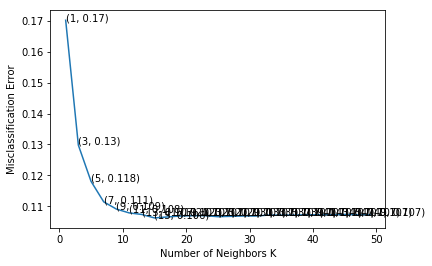

the misclassification error for each k value is :  [0.17  0.13  0.118 0.111 0.109 0.108 0.107 0.106 0.107 0.107 0.107 0.107
 0.107 0.107 0.107 0.107 0.107 0.107 0.107 0.107 0.107 0.107 0.107 0.107
 0.107]


In [36]:
fold_cross_validation(final_counts_tr,y_tr,y_test,10)


The accuracy of the knn classifier for k = 15 is 86.820000%
Accuracy on test set: 86.820%
Precision on test set: 0.869
Recall on test set: 0.998
F1-Score on test set: 0.929


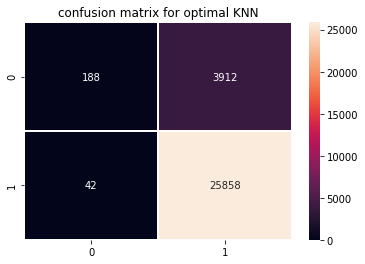

In [15]:
KNN_optimal(final_counts_tr,y_tr,final_counts_test,y_test,15)

# tf-idf 

In [17]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
tf_idf_tr = tf_idf_vect.fit_transform(X_tr.values)
tf_idf_cv = tf_idf_vect.transform(X_cv.values)
tf_idf_test = tf_idf_vect.transform(X_test.values)

In [18]:
tf_idf_tr = preprocessing.normalize(tf_idf_tr)
tf_idf_cv = preprocessing.normalize(tf_idf_cv)
tf_idf_test = preprocessing.normalize(tf_idf_test)

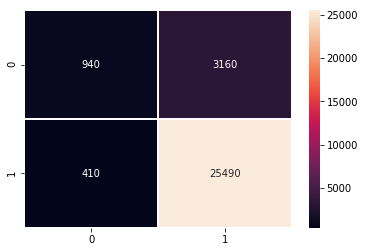

The best parameters are {'n_neighbors': 6} with a score of 0.90
Accuracy on test set: 88.100%
Precision on test set: 0.890
Recall on test set: 0.984
F1-Score on test set: 0.935


In [19]:
brute_force_knn(tf_idf_tr,y_tr,tf_idf_test,y_test)


The optimal number of neighbors is 7.


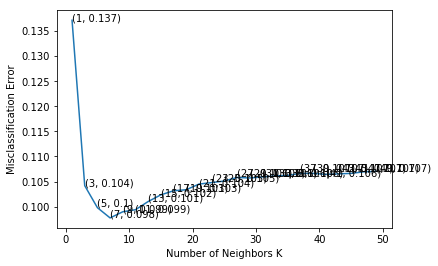

the misclassification error for each k value is :  [0.137 0.104 0.1   0.098 0.099 0.099 0.101 0.102 0.103 0.103 0.104 0.105
 0.105 0.106 0.106 0.106 0.106 0.106 0.107 0.107 0.106 0.107 0.107 0.107
 0.107]


In [45]:
fold_cross_validation(tf_idf_tr,y_tr,y_test,10)


The accuracy of the knn classifier for k = 7 is 87.960000%
Accuracy on test set: 87.960%
Precision on test set: 0.881
Recall on test set: 0.994
F1-Score on test set: 0.934


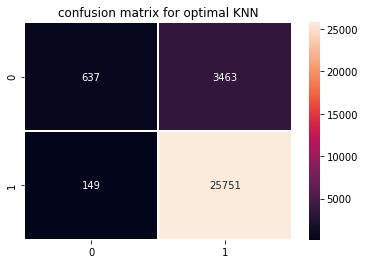

In [20]:
KNN_optimal(tf_idf_tr,y_tr,tf_idf_test,y_test,7)

# Avg Word2vec

In [21]:
# Using Google News Word2Vectors
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
    

In [22]:
import re
import nltk
nltk.download('stopwords')
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

[nltk_data] Downloading package stopwords to /Users/sapan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [23]:
# Train your own Word2Vec model using your own text corpus
import gensim
i=0
list_of_sentence_tr=[]
for sentence in X_tr.values:
    filtered_sentence=[]
    sentence=cleanhtml(sentence)
    for words in sentence.split():
        for cleaned_words in cleanpunc(words).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sentence_tr.append(filtered_sentence)

i=0
list_of_sentence_cv=[]
for sentence in X_cv.values:
    filtered_sentence=[]
    sentence=cleanhtml(sentence)
    for words in sentence.split():
        for cleaned_words in cleanpunc(words).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sentence_cv.append(filtered_sentence)
i=0
list_of_sentence_test=[]
for sentence in X_test.values:
    filtered_sentence=[]
    sentence=cleanhtml(sentence)
    for words in sentence.split():
        for cleaned_words in cleanpunc(words).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sentence_test.append(filtered_sentence)



In [24]:
w2v_model=gensim.models.Word2Vec(list_of_sentence_tr,min_count=5,size=50, workers=4)    

In [25]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  13711
sample words  ['this', 'witty', 'little', 'book', 'makes', 'my', 'son', 'laugh', 'at', 'loud', 'i', 'it', 'in', 'the', 'car', 'as', 'were', 'driving', 'along', 'and', 'he', 'always', 'can', 'sing', 'hes', 'learned', 'about', 'india', 'love', 'all', 'new', 'words', 'of', 'is', 'a', 'classic', 'am', 'willing', 'to', 'bet', 'will', 'still', 'be', 'able', 'from', 'memory', 'when', 'college', 'remember', 'seeing']


In [26]:
import numpy as np
# average Word2Vec
# compute average word2vec for each review.
sentence_vectors_tr = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in list_of_sentence_tr: # for each review/sentence
    sentence_vector_tr = np.zeros(50) # as word vectors are of zero length
    count_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence: # for each word in a review/sentence
        try:
            vector = w2v_model.wv[word]
            sentence_vector_tr += vector
            count_words += 1
        except:
            pass
    sentence_vector_tr /= count_words
    sentence_vectors_tr.append(sentence_vector_tr)
print(len(sentence_vectors_tr))
print(len(sentence_vectors_tr[0]))

49000
50


In [27]:
import numpy as np
# average Word2Vec
# compute average word2vec for each review.
sentence_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in list_of_sentence_cv: # for each review/sentence
    sentence_vector_cv = np.zeros(50) # as word vectors are of zero length
    count_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence: # for each word in a review/sentence
        try:
            vector = w2v_model.wv[word]
            sentence_vector_tr += vector
            count_words += 1
        except:
            pass
    sentence_vector_tr /= count_words
    sentence_vectors_cv.append(sentence_vector_tr)
print(len(sentence_vectors_cv))
print(len(sentence_vectors_cv[0]))

21000
50


In [28]:
import numpy as np
# average Word2Vec
# compute average word2vec for each review.
sentence_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in list_of_sentence_test: # for each review/sentence
    sentence_vector_test = np.zeros(50) # as word vectors are of zero length
    count_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence: # for each word in a review/sentence
        try:
            vector = w2v_model.wv[word]
            sentence_vector_tr += vector
            count_words += 1
        except:
            pass
    sentence_vector_tr /= count_words
    sentence_vectors_test.append(sentence_vector_tr)
print(len(sentence_vectors_test))
print(len(sentence_vectors_test[0]))

30000
50


In [29]:
sentence_vectors_tr = preprocessing.normalize(sentence_vectors_tr)
sentence_vectors_cv = preprocessing.normalize(sentence_vectors_cv)
sentence_vectors_test = preprocessing.normalize(sentence_vectors_test)

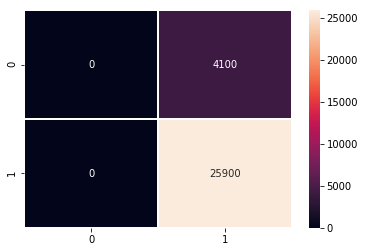

The best parameters are {'n_neighbors': 26} with a score of 0.90
Accuracy on test set: 86.333%
Precision on test set: 0.863
Recall on test set: 1.000
F1-Score on test set: 0.927


In [30]:
brute_force_knn(sentence_vectors_tr,y_tr,sentence_vectors_test,y_test)


The optimal number of neighbors is 17.


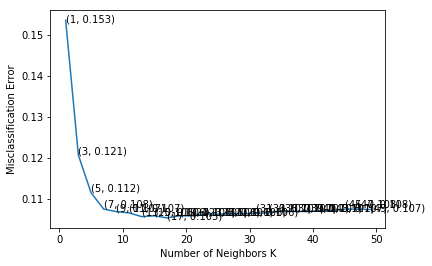

the misclassification error for each k value is :  [0.153 0.121 0.112 0.108 0.107 0.107 0.106 0.106 0.105 0.106 0.106 0.106
 0.106 0.106 0.106 0.107 0.107 0.107 0.107 0.107 0.107 0.107 0.108 0.108
 0.107]


In [55]:
fold_cross_validation(sentence_vectors_tr,y_tr,y_test,10)


The accuracy of the knn classifier for k = 17 is 86.333333%
Accuracy on test set: 86.333%
Precision on test set: 0.863
Recall on test set: 1.000
F1-Score on test set: 0.927


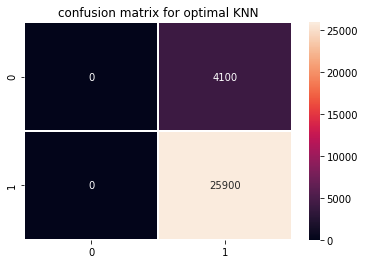

In [31]:
KNN_optimal(sentence_vectors_tr,y_tr,sentence_vectors_test,y_test,17)

# TF-IDF AVG Word2vec

In [32]:
from tqdm import tqdm

In [33]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(final.values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [34]:
# TF-IDF weighted Word2Vec
#tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_tr = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentence_tr): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            try:    
                tf_idf = dictionary[word] * sent.count(word)
            except KeyError:
                tf_idf = 0
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_tr.append(sent_vec)
    row += 1

100%|██████████| 49000/49000 [03:10<00:00, 257.79it/s]


In [35]:
# TF-IDF weighted Word2Vec
#tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentence_cv): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            try:    
                tf_idf = dictionary[word] * sent.count(word)
            except KeyError:
                tf_idf = 0
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1

100%|██████████| 21000/21000 [01:23<00:00, 250.82it/s]


In [36]:
# TF-IDF weighted Word2Vec
#tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentence_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            try:    
                tf_idf = dictionary[word] * sent.count(word)
            except KeyError:
                tf_idf = 0
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|██████████| 30000/30000 [01:58<00:00, 253.22it/s]


In [37]:
tfidf_sent_vectors_tr = preprocessing.normalize(tfidf_sent_vectors_tr)
tfidf_sent_vectors_cv = preprocessing.normalize(tfidf_sent_vectors_cv)
tfidf_sent_vectors_test = preprocessing.normalize(tfidf_sent_vectors_test)

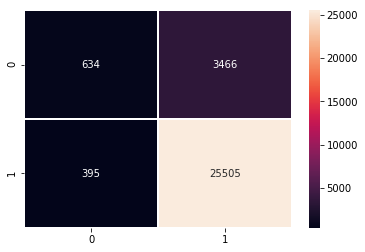

The best parameters are {'n_neighbors': 16} with a score of 0.89
Accuracy on test set: 87.130%
Precision on test set: 0.880
Recall on test set: 0.985
F1-Score on test set: 0.930


In [38]:
brute_force_knn(tfidf_sent_vectors_tr,y_tr,tfidf_sent_vectors_test,y_test)


The optimal number of neighbors is 31.


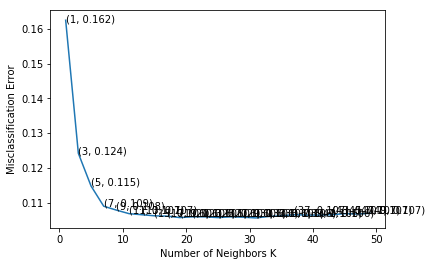

the misclassification error for each k value is :  [0.162 0.124 0.115 0.109 0.108 0.107 0.107 0.106 0.106 0.106 0.106 0.106
 0.106 0.106 0.106 0.106 0.106 0.106 0.107 0.106 0.106 0.107 0.107 0.107
 0.107]


In [66]:
fold_cross_validation(tfidf_sent_vectors_tr,y_tr,y_test,10)


The accuracy of the knn classifier for k = 31 is 87.050000%
Accuracy on test set: 87.050%
Precision on test set: 0.874
Recall on test set: 0.993
F1-Score on test set: 0.930


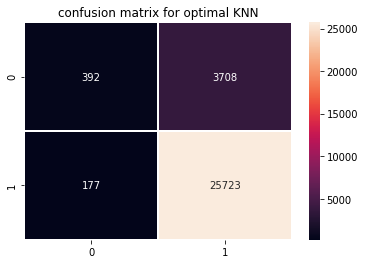

In [39]:
KNN_optimal(tfidf_sent_vectors_tr,y_tr,tfidf_sent_vectors_test,y_test,31)

# Conclusions

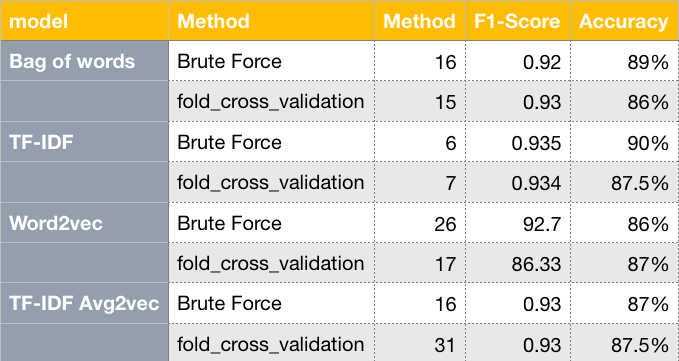
1. We will use F1-score as our performance matrix for this problem as this is highly imbalanced data
2. We got best result with TF-IDF with F1 score of .93.5 with 6 k value
3. The kd-tree and brute implementation of KNN gives relatively similar results
4. KNN is relatively very slow algorithm  to train
5. Avg word2vec model is not appropriate model for this problem as model is predicting only one class(majority)